In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib.patches import Patch
import math

In [4]:
# Path to data directory
#data_dir = Path("/home/jovyan/AICompetition/code/src/datasets")
data_dir = Path("../datasets")

In [5]:
# Load datasets
train_df = pd.read_csv(data_dir / "train.csv")
train_demographics_df = pd.read_csv(data_dir / "train_demographics.csv")
test_df = pd.read_csv(data_dir / "test.csv")
test_demographics_df = pd.read_csv(data_dir / "test_demographics.csv")

## Delete Sequences with too much gesture or transition phase

8151


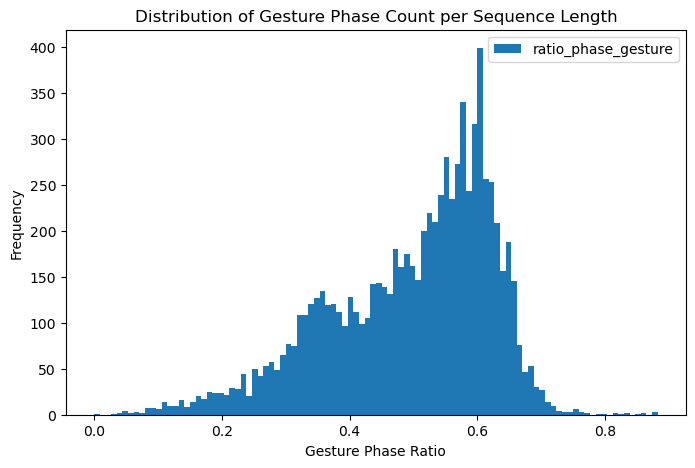

In [6]:
# Plot distribution of how much of each sequence is gesture (not transition) (gesture-phase ratio).
# high ratio -> mostly gesture, low ratio -> mostly transition
# print(sorted(train_df["phase"].dropna().unique().tolist()))

phases = ['Gesture', 'Transition']

def sanitize_col_name(s: str) -> str:
    return str(s).lower().replace(" ", "_")

# One row per sequence with basic meta + length + phase diversity
sequence_meta_df = (
    train_df.groupby("sequence_id", sort=False)
    .agg(
        sequence_type=("sequence_type", "first"),
        subject=("subject", "first"),
        orientation=("orientation", "first"),
        gesture=("gesture", "first"),
        seq_len=("sequence_counter", "size"),
        diversity_phase=("phase", "nunique"),
    )
    .reset_index()
)

# Phase counts via pivot
phase_counts = (
    train_df.assign(_one=1)
    .pivot_table(index="sequence_id", columns="phase", values="_one", aggfunc="sum", fill_value=0)
    .rename(columns=lambda c: f"count_phase_{sanitize_col_name(c)}")
    .reset_index()
)

# Join counts back
sequence_meta_df = sequence_meta_df.merge(phase_counts, on="sequence_id", how="left")

# Ratios = count / seq_len for provided phases
for p in phases:
    count_col = f"count_phase_{sanitize_col_name(p)}"
    ratio_col = f"ratio_phase_{sanitize_col_name(p)}"
    sequence_meta_df[ratio_col] = (
        sequence_meta_df.get(count_col, 0) / sequence_meta_df["seq_len"]
    )

print(sequence_meta_df.shape[0])
sequence_meta_df.head()

# Histogram of Gesture phase ratio
ax = sequence_meta_df["ratio_phase_gesture"].plot(
    kind="hist", bins=100, figsize=(8,5),
    title="Distribution of Gesture Phase Count per Sequence Length"
)
plt.xlabel("Gesture Phase Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Low gesture: 16 sequences
High gesture: 11 sequences


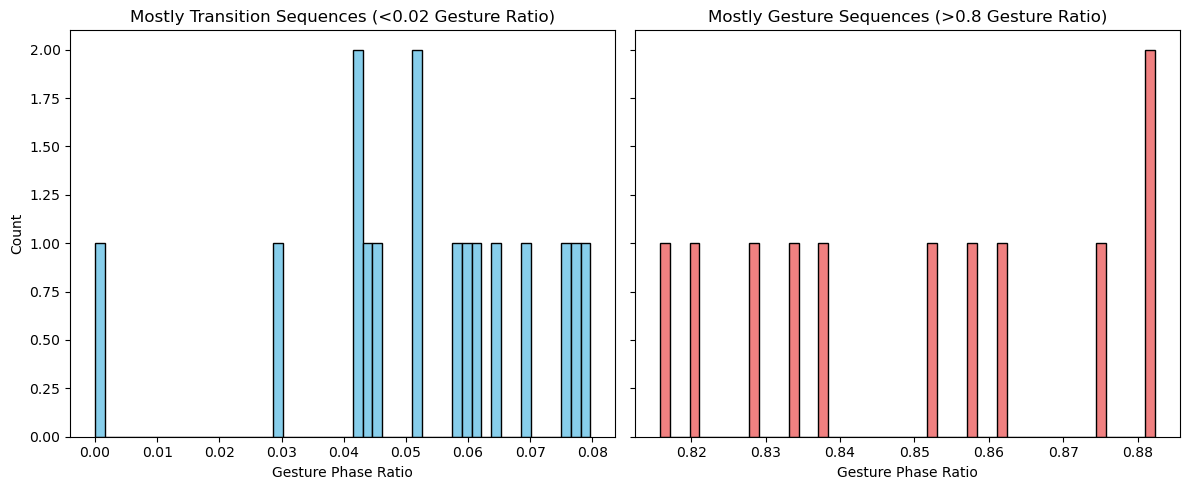

In [7]:
# Filter sequences by gesture ratio
low_gesture = sequence_meta_df[sequence_meta_df["ratio_phase_gesture"] < 0.08]
high_gesture = sequence_meta_df[sequence_meta_df["ratio_phase_gesture"] > 0.8]

print(f"Low gesture: {len(low_gesture)} sequences")
print(f"High gesture: {len(high_gesture)} sequences")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(low_gesture["ratio_phase_gesture"], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Mostly Transition Sequences (<0.02 Gesture Ratio)")
axes[0].set_xlabel("Gesture Phase Ratio")
axes[0].set_ylabel("Count")

axes[1].hist(high_gesture["ratio_phase_gesture"], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title("Mostly Gesture Sequences (>0.8 Gesture Ratio)")
axes[1].set_xlabel("Gesture Phase Ratio")

plt.tight_layout()
plt.show()


Low-gesture sequences (< 0.08): 16
['SEQ_003987', 'SEQ_004510', 'SEQ_010353', 'SEQ_011975', 'SEQ_013984', 'SEQ_014205', 'SEQ_015261', 'SEQ_016031', 'SEQ_028188', 'SEQ_039289', 'SEQ_047875', 'SEQ_048962', 'SEQ_054328', 'SEQ_060431', 'SEQ_060593', 'SEQ_065478']

High-gesture sequences (> 0.8): 11
['SEQ_011271', 'SEQ_011728', 'SEQ_014439', 'SEQ_015352', 'SEQ_015397', 'SEQ_017406', 'SEQ_032114', 'SEQ_037869', 'SEQ_038837', 'SEQ_059162', 'SEQ_065309']


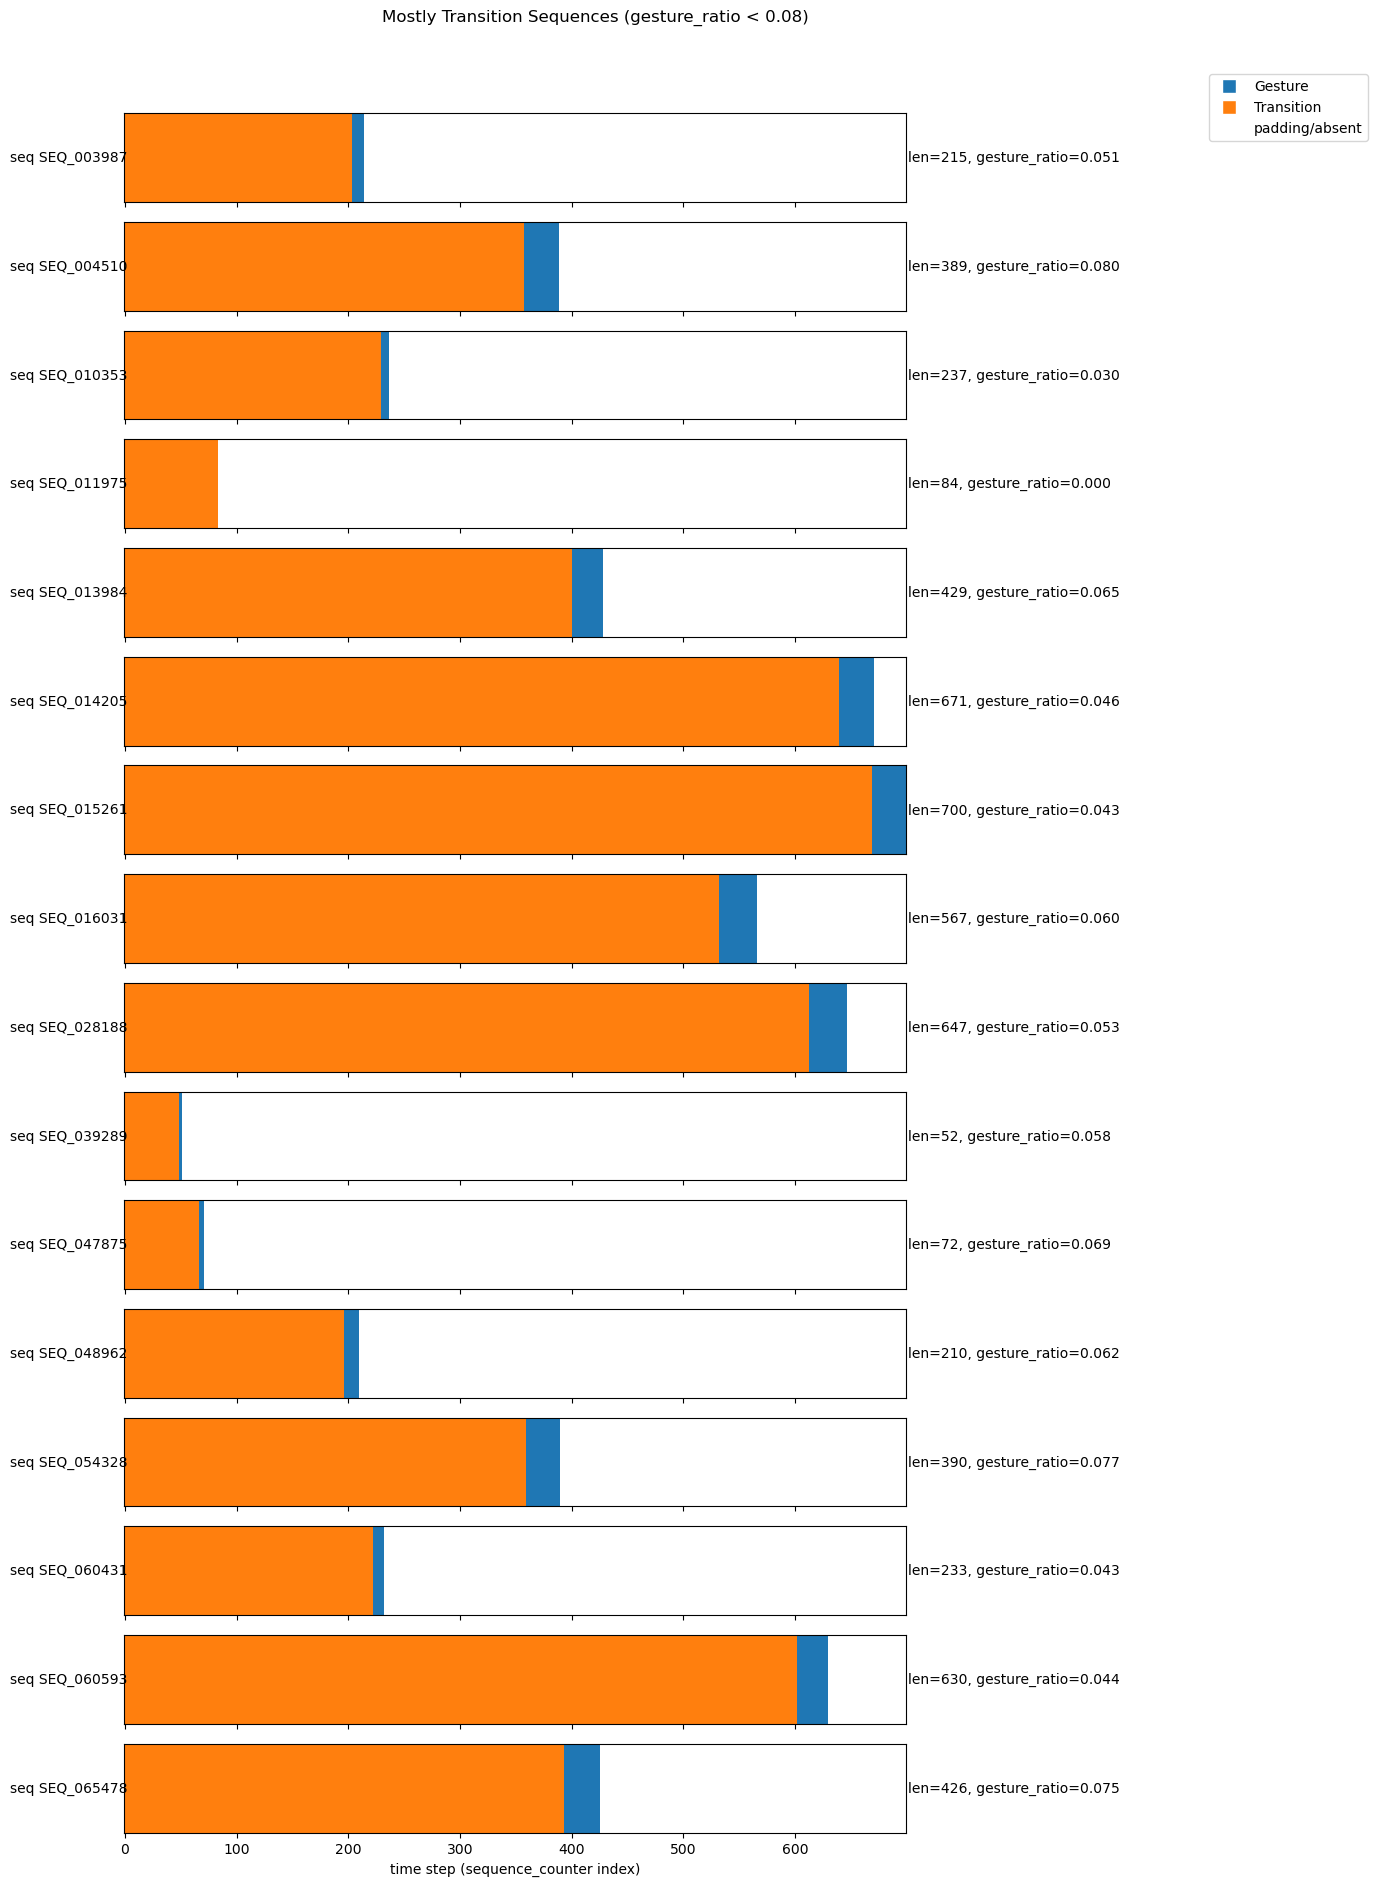

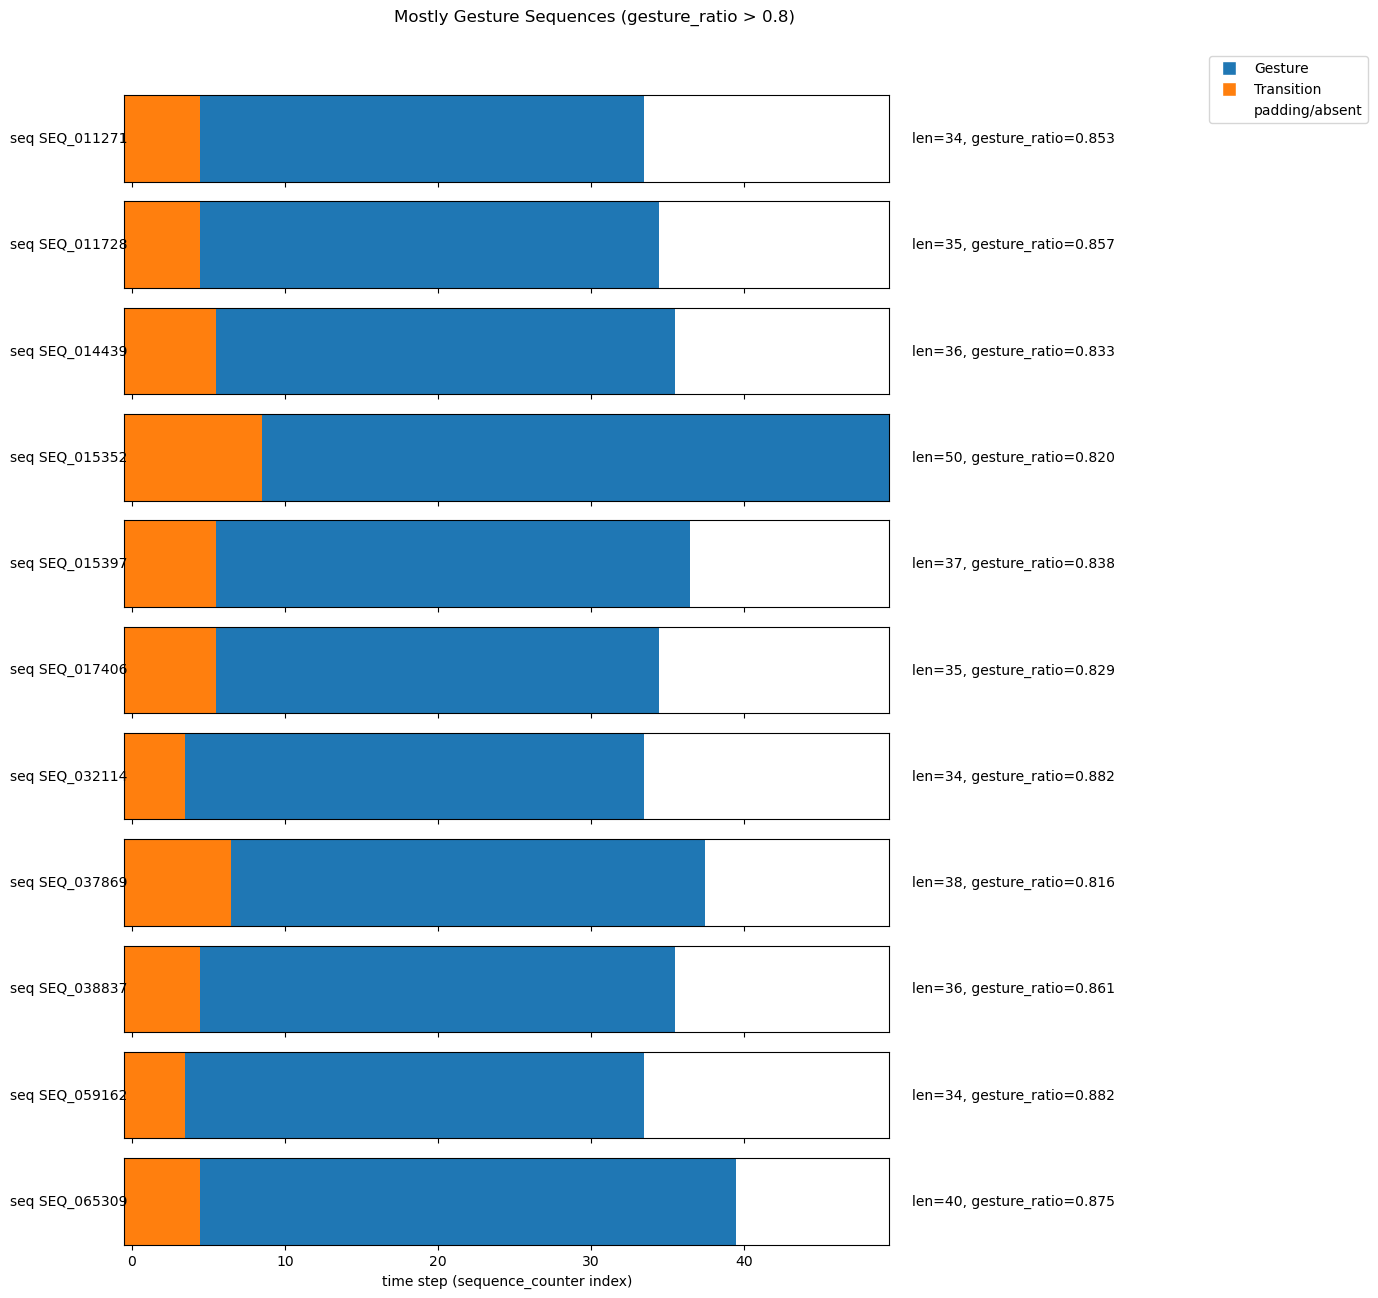

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# parameters
low_thresh = 0.08
high_thresh = 0.8
max_per_group = 20
phases = ['Gesture', 'Transition']

# ensure the ratio column exists (from your earlier code)
if "ratio_phase_gesture" not in sequence_meta_df.columns:
    raise ValueError("sequence_meta_df missing 'ratio_phase_gesture' column. Run previous aggregation code first.")

# filter sequence ids
low_gesture_ids = sequence_meta_df.loc[sequence_meta_df["ratio_phase_gesture"] < low_thresh, "sequence_id"].tolist()
high_gesture_ids = sequence_meta_df.loc[sequence_meta_df["ratio_phase_gesture"] > high_thresh, "sequence_id"].tolist()

print(f"Low-gesture sequences (< {low_thresh}): {len(low_gesture_ids)}")
print(low_gesture_ids[:max_per_group])
print()
print(f"High-gesture sequences (> {high_thresh}): {len(high_gesture_ids)}")
print(high_gesture_ids[:max_per_group])

# build a phase timeline array per sequence (ordered by sequence_counter)
def get_phase_timeline(sequence_id):
    seq = train_df[train_df["sequence_id"] == sequence_id].sort_values("sequence_counter")
    # if phase is missing, fill with "Transition" or np.nan as you prefer
    timeline = seq["phase"].fillna("Transition").astype(str).tolist()
    return timeline

# map phases to numeric for plotting and to colors
phase_to_int = {p: i for i, p in enumerate(phases)}

# color map 
cmap = plt.get_cmap("tab10")
n_colors = max(len(phase_to_int), 2)
colors = [cmap(i % 10) for i in range(n_colors)]

# reverse mapping for legend
int_to_phase = {v: k for k, v in phase_to_int.items()}

def plot_group(seq_ids, title):
    n = min(len(seq_ids), max_per_group)
    if n == 0:
        print(f"No sequences to plot for: {title}")
        return

    # compute maximal sequence length in the subset for consistent x-axis
    seq_lengths = [train_df[train_df["sequence_id"] == sid].shape[0] for sid in seq_ids[:n]]
    max_len = max(seq_lengths)

    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 1.2 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, sid in zip(axes, seq_ids[:n]):
        timeline = get_phase_timeline(sid)
        int_timeline = [phase_to_int.get(p, phase_to_int.get("Transition", 1)) for p in timeline]

        # pad to max_len for uniform width (use -1 for padded empty)
        padded = np.full(max_len, -1, dtype=int)
        padded[:len(int_timeline)] = int_timeline

        # create a color array where -1 => white/blank
        color_array = np.array([colors[i] if i >= 0 else (1.0, 1.0, 1.0, 1.0) for i in padded])

        # reshape to 2D image of shape (1, max_len, 4) so imshow draws a single horizontal row
        img = color_array.reshape(1, max_len, 4)

        ax.imshow(img, aspect='auto', interpolation='nearest')
        ax.set_yticks([])
        ax.set_xlim(-0.5, max_len - 0.5)
        ax.set_ylabel(f"seq {sid}", rotation=0, labelpad=40, va='center')
        # annotate length and gesture ratio for quick context (if available)
        row = sequence_meta_df[sequence_meta_df["sequence_id"] == sid]
        if not row.empty:
            seq_len = int(row["seq_len"].iloc[0])
            ratio = float(row["ratio_phase_gesture"].iloc[0])
            ax.text(max_len + 1, 0, f"len={seq_len}, gesture_ratio={ratio:.3f}", va='center')

    # legend
    legend_patches = []
    for i in sorted(int_to_phase.keys()):
        patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10)
        legend_patches.append((patch, int_to_phase[i]))
    # add a blank patch label
    legend_patches.append((plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=(1,1,1,1), markersize=10), "padding/absent"))

    patches, labels = zip(*legend_patches)
    fig.legend(patches, labels, loc='upper right', bbox_to_anchor=(1.15, 0.95))
    fig.suptitle(title)
    plt.xlabel("time step (sequence_counter index)")
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

# Plot low-gesture (mostly transition)
plot_group(low_gesture_ids, f"Mostly Transition Sequences (gesture_ratio < {low_thresh})")

# Plot high-gesture (mostly gesture)
plot_group(high_gesture_ids, f"Mostly Gesture Sequences (gesture_ratio > {high_thresh})")


In [9]:
to_drop_ids = set(low_gesture_ids + high_gesture_ids)
print(f"Total sequences to drop: {len(to_drop_ids)}")
print(to_drop_ids)


Total sequences to drop: 27
{'SEQ_013984', 'SEQ_037869', 'SEQ_003987', 'SEQ_004510', 'SEQ_010353', 'SEQ_028188', 'SEQ_060431', 'SEQ_060593', 'SEQ_047875', 'SEQ_014205', 'SEQ_032114', 'SEQ_038837', 'SEQ_014439', 'SEQ_011728', 'SEQ_011975', 'SEQ_015352', 'SEQ_065309', 'SEQ_065478', 'SEQ_039289', 'SEQ_054328', 'SEQ_059162', 'SEQ_048962', 'SEQ_011271', 'SEQ_017406', 'SEQ_015261', 'SEQ_015397', 'SEQ_016031'}


In [10]:
train_df.shape

(574945, 341)

In [11]:
# remove sequences with too much gesture or transition phase
train_df = train_df[~train_df["sequence_id"].isin(to_drop_ids)].copy()

In [12]:
train_df.shape

(568584, 341)

In [13]:
# test if it was successfully removed
assert not train_df["sequence_id"].isin(to_drop_ids).any()


## Look at subjects who didn't wear the device correctly

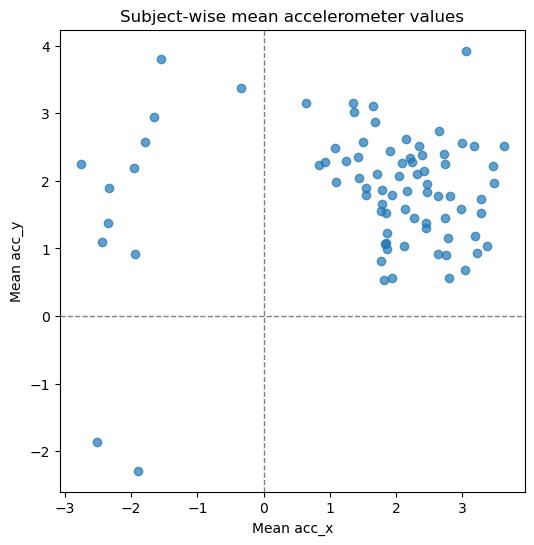

In [14]:
# Subject acc x / acc y means
subj_means = train_df.groupby("subject")[["acc_x","acc_y"]].mean()

plt.figure(figsize=(6,6))
plt.scatter(subj_means["acc_x"], subj_means["acc_y"], alpha=0.7)

plt.axhline(0, color="grey", lw=1, ls="--")
plt.axvline(0, color="grey", lw=1, ls="--")
plt.xlabel("Mean acc_x")
plt.ylabel("Mean acc_y")
plt.title("Subject-wise mean accelerometer values")
plt.show()



In [15]:
# Compute subject-level means
subj_means = train_df.groupby("subject")[["acc_x","acc_y"]].mean()

# Z-score each subject relative to the group
from scipy.stats import zscore
z = np.abs(zscore(subj_means))

# Compute a combined distance per subject
subj_means["outlier_score"] = z.max(axis=1)

# Flag outliers
outliers = subj_means[subj_means["outlier_score"] > 3]
print(outliers)


                acc_x     acc_y  outlier_score
subject                                       
SUBJ_019262 -1.899601 -2.288049       4.264196
SUBJ_045235 -2.514676 -1.859195       3.819970


In [16]:
# subjects to fix
mask = train_df["subject"].isin(["SUBJ_019262", "SUBJ_045235"])

# negate all numeric channels EXCEPT acc_z and linear_acc_z
num_cols = train_df.select_dtypes(include="number").columns
keep = {"acc_z", "linear_acc_z"}
flip_cols = [c for c in num_cols if c not in keep]
train_df.loc[mask, flip_cols] = -train_df.loc[mask, flip_cols].to_numpy()

# set TOF columns to NaN
tof_cols = [c for c in train_df.columns if c.lower().startswith("tof")]
if tof_cols:
    train_df.loc[mask, tof_cols] = np.nan

# 3) rotate quaternions 180° about z: q' = q ⊗ [0,0,0,1] = (-z, y, -x, w)
quat_cols = ["qw","qx","qy","qz"]
if all(c in train_df.columns for c in quat_cols):
    q = train_df.loc[mask, quat_cols].to_numpy()
    qw, qx, qy, qz = q.T
    q_rot = np.column_stack([-qz, qy, -qx, qw])
    train_df.loc[mask, quat_cols] = q_rot


In [17]:
train_df.shape

(568584, 341)

## Remove outliers

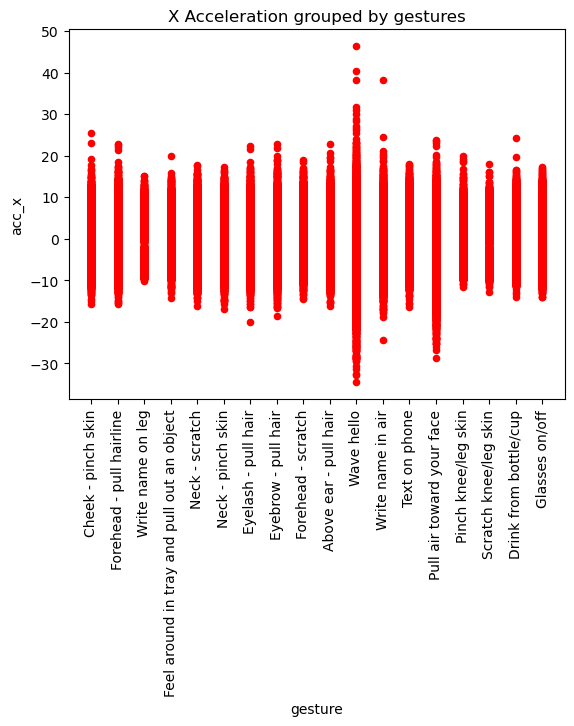

In [18]:
ax = train_df.plot(kind='scatter', x='gesture', y='acc_x', color='red', title='X Acceleration grouped by gestures')
ax.tick_params(axis='x', labelrotation=90)


In [19]:
# Remove outliers per group using standard deviation
def remove_outliers_std(group, col, n_std=5):
    mean = group[col].mean()
    std = group[col].std()
    # If a group has 1 item (NaN std) or zero variance, keep it as-is
    if pd.isna(std) or std == 0:
        return group
    lower, upper = mean - n_std * std, mean + n_std * std

    # keep NaNs and -1 values as-is
    return group[group[col].isna() | (group[col] == -1) | ((group[col] >= lower) & (group[col] <= upper))]

In [20]:
# Apply per gesture group
# train_df = (train_df.groupby('gesture', group_keys=False).apply(remove_outliers_std, col='acc_x', n_std=3))

In [21]:
train_df.shape

(568584, 341)

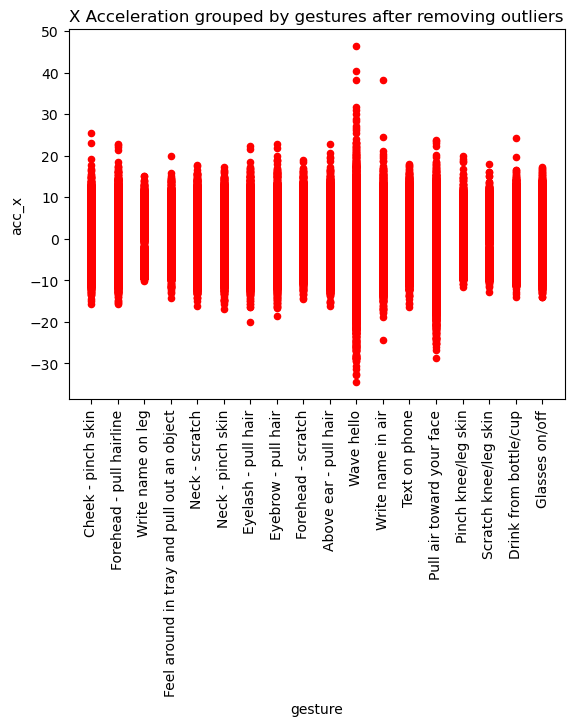

In [22]:
ax = train_df.plot(kind='scatter', x='gesture', y='acc_x', color='red', title='X Acceleration grouped by gestures after removing outliers')
ax.tick_params(axis='x', labelrotation=90)

In [23]:
# Apply for all numeric columns per gesture
def remove_all_outliers(df, n_std=5):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df = df.groupby("gesture", group_keys=False).apply(remove_outliers_std, col=col, n_std=n_std)
    return df

In [24]:
# way to many data points get lost
#train_df = remove_all_outliers(train_df, n_std=3)

In [25]:
train_df.shape

(568584, 341)

In [26]:

train_df = remove_all_outliers(train_df, n_std=5)

/tmp/ipykernel_257/3411322418.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("gesture", group_keys=False).apply(remove_outliers_std, col=col, n_std=n_std)
/tmp/ipykernel_257/3411322418.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("gesture", group_keys=False).apply(remove_outliers_std, col=col, n_std=n_std)
/tmp/ipykernel_257/3411322418.py:5: DeprecationWarning: Da

In [85]:
train_df.shape

(456716, 341)

In [95]:
# Less strict than filtering each column separately, since rows are only dropped if truly outside limits.
# Remove outliers per gesture using mean ± n_std*std across all numeric columns in one pass.
# NaN and -1 values are kept. 
def remove_outliers_all_cols(group, n_std=4):
    num_cols = group.select_dtypes(include=[np.number]).columns
    mask = pd.Series(True, index=group.index)
    
    for col in num_cols:
        mean = group[col].mean()
        std = group[col].std()
        if pd.isna(std) or std == 0:
            continue
        lower, upper = mean - n_std * std, mean + n_std * std
        
        # erlaubt NaN und -1, filtert nur echte Werte
        mask &= group[col].isna() | (group[col] == -1) | ((group[col] >= lower) & (group[col] <= upper))
    
    return group[mask]

traind_df = train_df.groupby("gesture", group_keys=False).apply(remove_outliers_all_cols, n_std=5)


/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_6627/3561361395.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  traind_df = train_df.groupby("gesture", group_keys=False).apply(remove_outliers_all_cols, n_std=5)


In [27]:
train_df.shape

(457218, 341)

## Fill NaNs

In [28]:
# fill NaNs with zero
num_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[num_cols] = train_df[num_cols].fillna(0)

## Save cleaned df as csv

In [29]:
out_path = Path("../datasets") / "train_df_clean.csv"

# save cleaned DataFrame
train_df.to_csv(out_path, index=False)